In [7]:
from qiskit import *

a_low = QuantumRegister(1, 'a_low')
a_high = QuantumRegister(1, 'a_high')
b_low = QuantumRegister(1, 'b_low')
b_high = QuantumRegister(1, 'b_high')
c_low = QuantumRegister(1, 'c_low')
c_high = QuantumRegister(1, 'c_high')
d_low = QuantumRegister(1, 'd_low')
d_high = QuantumRegister(1, 'd_high')

anc = QuantumRegister(20, 'anc')
anc_mct = QuantumRegister(9, 'mct_ancilla')
flag = QuantumRegister(1, 'flag')
qc = QuantumCircuit(a_low, a_high, b_low, b_high, c_low, c_high, d_low, d_high, anc)
qc.draw()

a_low: 
        
a_high: 
        
 b_low: 
        
b_high: 
        
 c_low: 
        
c_high: 
        
 d_low: 
        
d_high: 
        
 anc_0: 
        
 anc_1: 
        
 anc_2: 
        
 anc_3: 
        
 anc_4: 
        
 anc_5: 
        
 anc_6: 
        
 anc_7: 
        
 anc_8: 
        
 anc_9: 
        
anc_10: 
        
anc_11: 
        
anc_12: 
        
anc_13: 
        
anc_14: 
        
anc_15: 
        
anc_16: 
        
anc_17: 
        
anc_18: 
        
anc_19:

## Encoding of Input Values

## Function Definition for Inequality, equality and addition

In [12]:
def check_inequality(qc, x_low, x_high, y_low, y_high, res_anc):
    qc.cx(x_high, y_high)
    qc.x(y_high)
    qc.cx(x_low, y_low)
    qc.x(y_low)
    qc.rccx(y_low, y_high, res_anc)
    
    #Uncompute
    qc.x(y_low)
    qc.cx(x_low, y_low)
    qc.x(y_high)
    qc.cx(x_high, y_high)
    return qc

def check_equality(qc, x_low, x_high, y_low, y_high, res_anc):
    qc.cx(x_high, y_high)
    qc.cx(x_low, y_low)
    qc.cx(y_low, y_high)
    qc.cx(y_high, res_anc)
    qc.x(res_anc)
    
    #Uncompute
    qc.cx(y_high, res_anc)
    qc.cx(y_low, y_high)
    qc.cx(x_low, y_low)
    qc.cx(x_high, y_high)
    return qc

def add_two_numbers(qc, x_low, x_high, y_low, y_high, ancs, res_anc):
    qc.cx(x_low, y_low)
    qc.rccx(x_low, y_low, ancs[0])
    qc.cx(y_low, x_low)
    qc.cx(y_high, x_high)
    qc.rccx(x_low, x_high, ancs[1])
    qc.rccx(x_high, y_high, ancs[2])
    qc.x(ancs[2])
    qc.rccx(ancs[2], ancs[0], ancs[3])
    qc.x(ancs[1])
    qc.x(ancs[3])
    qc.x(res_anc)
    qc.rccx(ancs[1], ancs[3], res_anc)
    
    #Uncompute
    qc.x(ancs[3])
    qc.x(ancs[1])
    qc.rccx(ancs[2], ancs[0], ancs[3])
    qc.x(ancs[2])
    qc.rccx(x_high, y_high, ancs[2])
    qc.rccx(x_low, x_high, ancs[1])
    qc.cx(y_high, x_high)
    qc.rccx(x_low, y_low, ancs[0])
    qc.cx(y_low, x_low)
    qc.cx(x_low, y_low)
    
    return qc

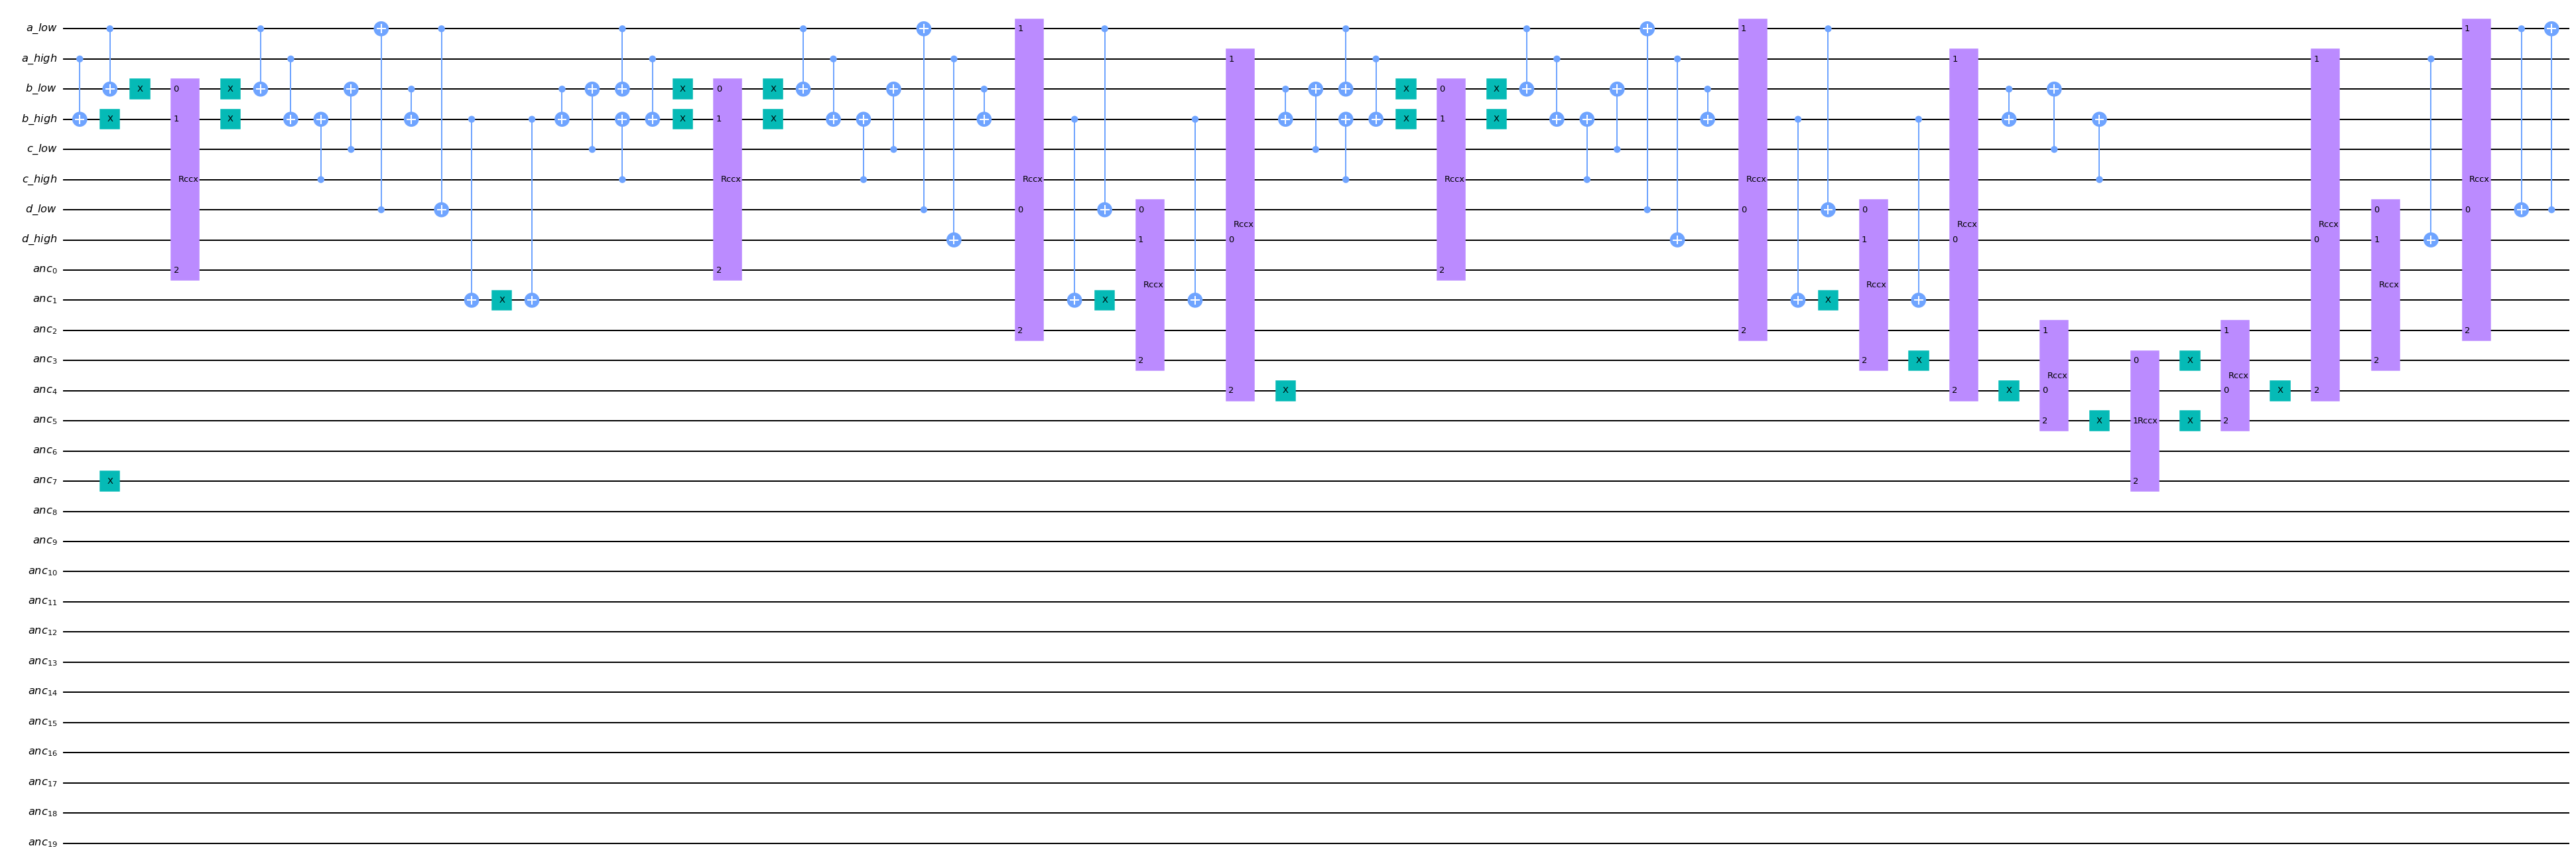

In [13]:
check_inequality(qc, a_low, a_high, b_low, b_high, anc[0])
check_equality(qc, c_low, c_high, b_low, b_high, anc[1])
add_two_numbers(qc, d_low, d_high, a_low, a_high, anc[2:7], anc[7])
qc.draw(output='mpl', fold=-1)

# Archiv: Classiq

# Classiq Coding Competition: Kakuro

Team: MQT ProblemSolver

Contributors: Lukas Burgholzer and Nils Quetschlich

In the following, we describe how 
- each of the constraints is implemented,
- these constraints are aggregated into the oracle,
- the full grover algorithm is created,
- we optimized the constraints leading to an oracle with 152 cx gates.

# Constraints

In the following, quantum circuits for all individual constraints are constructed. All circuits compute the result of the constraint on a separate qubit and uncompute any intermediate results. Some of these uncomputation steps are skipped later on.

In [ ]:
from qiskit import *

x0 = QuantumRegister(1, 'x0')
x1 = QuantumRegister(1, 'x1')
x2 = QuantumRegister(1, 'x2')
x3MSQ = QuantumRegister(1, 'x3MSQ')
x3LSQ = QuantumRegister(1, 'x3LSQ')
x4 = QuantumRegister(1, 'x4')
x5 = QuantumRegister(1, 'x5')
x6 = QuantumRegister(1, 'x6')
anc = QuantumRegister(13, 'anc')
anc_mct = QuantumRegister(9, 'mct_ancilla')
flag = QuantumRegister(1, 'flag')

ninputs = x0.size + x1.size + x2.size + x3LSQ.size + x3MSQ.size + x4.size + x5.size + x6.size
nqubits = x0.size + x1.size + x2.size + x3LSQ.size + x3MSQ.size + x4.size + x5.size + x6.size + flag.size
nancilla = anc.size + anc_mct.size
ncond = 11

## x0 != x1

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x0,x1)
qc.cx(x1,anc[0])
qc.cx(x0,x1)

qc.draw(idle_wires=False, output='mpl')

## x5 != x6

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x5,x6)
qc.cx(x6,anc[1])
qc.cx(x5,x6)

qc.draw(idle_wires=False, output='mpl')

## x0 != x2

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x0,x2)
qc.cx(x2,anc[2])
qc.cx(x0,x2)

qc.draw(idle_wires=False, output='mpl')

## x1 != x5

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x1,x5)
qc.cx(x5,anc[3])
qc.cx(x1,x5)

qc.draw(idle_wires=False, output='mpl')

## x4 != x6

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x4,x6)
qc.cx(x6,anc[4])
qc.cx(x4,x6)

qc.draw(idle_wires=False, output='mpl')

## x3 != x4

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x3LSQ, x4)
qc.x(x4)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x4, anc[5])
qc.x(x4)
qc.cx(x3LSQ, x4)
qc.x(x3MSQ)
qc.x(anc[5])

qc.draw(idle_wires=False, output='mpl')

## x1 != x3

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x3LSQ, x1)
qc.x(x1)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x1, anc[6])
qc.x(x1)
qc.cx(x3LSQ, x1)
qc.x(x3MSQ)
qc.x(anc[6])

qc.draw(idle_wires=False, output='mpl')

## x3 != x5

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x3LSQ, x5)
qc.x(x5)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x5, anc[7])
qc.x(x5)
qc.cx(x3LSQ, x5)
qc.x(x3MSQ)
qc.x(anc[7])

qc.draw(idle_wires=False, output='mpl')

## x3 == 2

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.x(x3LSQ)
qc.rccx(x3LSQ, x3MSQ, anc[8])
qc.x(x3LSQ)

qc.draw(idle_wires=False, output='mpl')

## x2 + 2 != x3

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.cx(x2, x3LSQ)
qc.x(x3LSQ)
qc.rccx(x3MSQ, x3LSQ, anc[9])
qc.x(x3LSQ)
qc.x(anc[9])
qc.cx(x2, x3LSQ)

qc.draw(idle_wires=False, output='mpl')

## x2 + x4 + x3 == 3

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc)

qc.rccx(x3LSQ, x2, anc[11])
qc.cx(x3LSQ, x2)
qc.rccx(x2, x4, anc[11])
qc.cx(x2, x4)
qc.rccx(x3MSQ, anc[11], anc[12])
qc.cx(x3MSQ, anc[11])
qc.x(anc[12])

qc.rcccx(x4, anc[11], anc[12], anc[10])

qc.x(anc[12])
qc.cx(x3MSQ, anc[11])
qc.rccx(x3MSQ, anc[11], anc[12])
qc.cx(x2, x4)
qc.rccx(x2, x4, anc[11])
qc.cx(x3LSQ, x2)
qc.rccx(x3LSQ, x2, anc[11])

qc.draw(idle_wires=False, output='mpl')

# Straight-forward Oracle Definition

In the following, all constraints are combined in a sequential fashion and a large multi-controlled Toffoli gate is used to mark the desired states. Then all constraints are properly uncomputed again.

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc, anc_mct, flag)

# (x0 != x1) -> anc[0]
qc.cx(x0,x1)
qc.cx(x1,anc[0])
qc.cx(x0,x1)
qc.barrier()

# (x5 != x6) -> anc[1]
qc.cx(x5,x6)
qc.cx(x6,anc[1])
qc.cx(x5,x6)
qc.barrier()

# (x0 != x2) -> anc[2]
qc.cx(x0,x2)
qc.cx(x2,anc[2])
qc.cx(x0,x2)
qc.barrier()

# (x1 != x5) -> anc[3]
qc.cx(x1,x5)
qc.cx(x5,anc[3])
qc.cx(x1,x5)
qc.barrier()

# (x4 != x6) -> anc[4]
qc.cx(x4,x6)
qc.cx(x6,anc[4])
qc.cx(x4,x6)
qc.barrier()

# (x3 != x4) -> anc[5]
qc.cx(x3LSQ, x4)
qc.x(x4)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x4, anc[5])
qc.x(x4)
qc.cx(x3LSQ, x4)
qc.x(x3MSQ)
qc.x(anc[5])
qc.barrier()

# (x1 != x3) -> anc[6]
qc.cx(x3LSQ, x1)
qc.x(x1)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x1, anc[6])
qc.x(x1)
qc.cx(x3LSQ, x1)
qc.x(x3MSQ)
qc.x(anc[6])
qc.barrier()

# (x3 != x5) -> anc[7]
qc.cx(x3LSQ, x5)
qc.x(x5)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x5, anc[7])
qc.x(x5)
qc.cx(x3LSQ, x5)
qc.x(x3MSQ)
qc.x(anc[7])
qc.barrier()

# (x3 == 2) -> anc[8]
qc.x(x3LSQ)
qc.rccx(x3LSQ, x3MSQ, anc[8])
qc.x(x3LSQ)
qc.barrier()

# (x2 + 2 != x3) -> anc[9]
qc.cx(x2, x3LSQ)
qc.x(x3LSQ)
qc.rccx(x3MSQ, x3LSQ, anc[9])
qc.x(x3LSQ)
qc.x(anc[9])
qc.cx(x2, x3LSQ)
qc.barrier()


# (x2 + x4 + x3 == 3) -> anc[10]
qc.rccx(x3LSQ, x2, anc[11])
qc.cx(x3LSQ, x2)
qc.rccx(x2, x4, anc[11])
qc.cx(x2, x4)
qc.rccx(x3MSQ, anc[11], anc[12])
qc.cx(x3MSQ, anc[11])
qc.x(anc[12])

qc.rcccx(x4, anc[11], anc[12], anc[10])

qc.x(anc[12])
qc.cx(x3MSQ, anc[11])
qc.rccx(x3MSQ, anc[11], anc[12])
qc.cx(x2, x4)
qc.rccx(x2, x4, anc[11])
qc.cx(x3LSQ, x2)
qc.rccx(x3LSQ, x2, anc[11])
qc.barrier()

compute = qc.to_instruction()

# mark solution
qc.mct(anc[0:ncond], flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
uncompute = compute.inverse()
uncompute.name = 'uncompute'
qc.append(uncompute, range(qc.num_qubits))

print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])

qc.qasm(filename='oracle.qasm')
oracle = qc.to_instruction(label='oracle')
qc.draw(fold=-1, output='mpl')

# Embedding in Grover Algorithm

In the following, the constructed oracle is embedded into Grover's algorithm and simulated using the MQT DDSIM quantum simulator (available via `pip install mqt.ddsim`). The expected result is `10001110`, which corresponds to the original problem solution

```
 *   | (5) | (3) | (1) |
------------------------
 (3) |  2  |  1  |  *  |
------------------------
 (5) |  3  |  2  |  0  |
------------------------
 (1) |  *  |  0  |  1  |
------------------------
```

In [ ]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim

qc = QuantumCircuit(nqubits+nancilla, ninputs)
qc.h(range(ninputs))
qc.x(nqubits+nancilla-1)
qc.h(nqubits+nancilla-1)

num_iterations = Grover.optimal_num_iterations(1, ninputs)

#print(num_iterations)
for _ in range(num_iterations):
    qc.append(oracle, range(nqubits+nancilla))
    qc.h(range(ninputs))
    qc.x(range(ninputs))
    qc.mcp(np.pi, list(range(ninputs-1)), ninputs-1)
    qc.x(range(ninputs))
    qc.h(range(ninputs))
qc.measure(range(ninputs), range(ninputs))
qc.qasm(filename='grover_algorithm.qasm')

backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
job = execute(qc, backend, shots=10000)
counts = job.result().get_counts(qc)
print(counts)

In [ ]:
qc.draw(fold=-1, output='mpl')

# Optimizing the Oracle

In the following, several aspects of the oracle will be subsequently optimized.


The `x2 + x3 + x4 == 3` constraint requires quite some computations and, correspondingly, uncomputations. Some of these actually cancel with the uncomputation of the whole oracle and, hence, can be removed.

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc, anc_mct, flag)

# (x0 != x1) -> anc[0]
qc.cx(x0,x1)
qc.cx(x1,anc[0])
qc.cx(x0,x1)
qc.barrier()

# (x5 != x6) -> anc[1]
qc.cx(x5,x6)
qc.cx(x6,anc[1])
qc.cx(x5,x6)
qc.barrier()

# (x0 != x2) -> anc[2]
qc.cx(x0,x2)
qc.cx(x2,anc[2])
qc.cx(x0,x2)
qc.barrier()

# (x1 != x5) -> anc[3]
qc.cx(x1,x5)
qc.cx(x5,anc[3])
qc.cx(x1,x5)
qc.barrier()

# (x4 != x6) -> anc[4]
qc.cx(x4,x6)
qc.cx(x6,anc[4])
qc.cx(x4,x6)
qc.barrier()

# (x3 != x4) -> anc[5]
qc.cx(x3LSQ, x4)
qc.x(x4)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x4, anc[5])
qc.x(x4)
qc.cx(x3LSQ, x4)
qc.x(x3MSQ)
qc.x(anc[5])
qc.barrier()

# (x1 != x3) -> anc[6]
qc.cx(x3LSQ, x1)
qc.x(x1)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x1, anc[6])
qc.x(x1)
qc.cx(x3LSQ, x1)
qc.x(x3MSQ)
qc.x(anc[6])
qc.barrier()

# (x3 != x5) -> anc[7]
qc.cx(x3LSQ, x5)
qc.x(x5)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x5, anc[7])
qc.x(x5)
qc.cx(x3LSQ, x5)
qc.x(x3MSQ)
qc.x(anc[7])
qc.barrier()

# (x3 == 2) -> anc[8]
qc.x(x3LSQ)
qc.rccx(x3LSQ, x3MSQ, anc[8])
qc.x(x3LSQ)
qc.barrier()

# (x2 + 2 != x3) -> anc[9]
qc.cx(x2, x3LSQ)
qc.x(x3LSQ)
qc.rccx(x3MSQ, x3LSQ, anc[9])
qc.x(x3LSQ)
qc.x(anc[9])
qc.cx(x2, x3LSQ)
qc.barrier()


# (x2 + x4 + x3 == 3) -> anc[10]
qc.rccx(x3LSQ, x2, anc[11])
qc.cx(x3LSQ, x2)
qc.rccx(x2, x4, anc[11])
qc.cx(x2, x4)
qc.rccx(x3MSQ, anc[11], anc[12])
qc.cx(x3MSQ, anc[11])
qc.x(anc[12])

qc.rcccx(x4, anc[11], anc[12], anc[10])

qc.barrier()

compute = qc.to_instruction()

# mark solution
qc.mct(anc[0:ncond], flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
uncompute = compute.inverse()
uncompute.name = 'uncompute'
qc.append(uncompute, range(qc.num_qubits))

print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])

oracle = qc.to_instruction(label='oracle')
qc.draw(fold=-1, output='mpl')

By rearranging the constraints a bit, all but one of the `x_i != x_j` constraints where neither `i` nor `j` is equal to `3` can be computed inplace (without any ancillaries)

In [ ]:
anc = QuantumRegister(9, 'anc')
nancilla = anc.size + anc_mct.size
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc, anc_mct, flag)

# (x3 != x4) -> anc[0]
qc.cx(x3LSQ, x4)
qc.x(x4)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x4, anc[0])
qc.x(x4)
qc.cx(x3LSQ, x4)
qc.x(x3MSQ)
qc.x(anc[0])
qc.barrier()

# (x1 != x3) -> anc[1]
qc.cx(x3LSQ, x1)
qc.x(x1)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x1, anc[1])
qc.x(x1)
qc.cx(x3LSQ, x1)
qc.x(x3MSQ)
qc.x(anc[1])
qc.barrier()

# (x3 != x5) -> anc[2]
qc.cx(x3LSQ, x5)
qc.x(x5)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x5, anc[2])
qc.x(x5)
qc.cx(x3LSQ, x5)
qc.x(x3MSQ)
qc.x(anc[2])
qc.barrier()

# (x3 == 2) -> anc[3]
qc.x(x3LSQ)
qc.rccx(x3LSQ, x3MSQ, anc[3])
qc.x(x3LSQ)
qc.barrier()

# (x2 + 2 != x3) -> anc[4]
qc.cx(x3LSQ, x2)
qc.x(x2)
qc.rccx(x3MSQ, x2, anc[4])
qc.x(x2)
qc.x(anc[4])
qc.cx(x3LSQ, x2)
qc.barrier()

# (x0 != x2) -> anc[5]
qc.cx(x2,x0)
qc.cx(x0,anc[5])
qc.cx(x2,x0)
qc.barrier()

# (x0 != x1) -> x0
qc.cx(x1, x0)
qc.barrier()

# (x1 != x5) -> x1
qc.cx(x5, x1)
qc.barrier()

# (x5 != x6) -> x5
qc.cx(x6, x5)
qc.barrier()

# (x4 != x6) -> x6
qc.cx(x4,x6)
qc.barrier()

# (x2 + x4 + x3 == 3) -> anc[7]
qc.rccx(x3LSQ, x2, anc[7])
qc.cx(x3LSQ, x2)
qc.rccx(x2, x4, anc[7])
qc.cx(x2, x4)
qc.rccx(x3MSQ, anc[7], anc[8])
qc.cx(x3MSQ, anc[7])
qc.x(anc[8])
qc.rcccx(x4, anc[7], anc[8], anc[6])
qc.barrier()

compute = qc.to_instruction()

# mark solution
qc.mct([x0, x1, x5, x6] + anc[0:ncond-4], flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
uncompute = compute.inverse()
uncompute.name = 'uncompute'
qc.append(uncompute, range(qc.num_qubits))

print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])

oracle = qc.to_instruction(label='oracle')
qc.draw(fold=-1, output='mpl', idle_wires=False)

Further reductions can be achieved by exchanging the roles of `x2` and `x4` in the addition constraint and moving the `x3 != x4` constraint after the addition.

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc, anc_mct, flag)

# (x1 != x3) -> anc[1]
qc.cx(x3LSQ, x1)
qc.x(x1)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x1, anc[1])
qc.x(x1)
qc.cx(x3LSQ, x1)
qc.x(x3MSQ)
qc.x(anc[1])
qc.barrier()

# (x3 != x5) -> anc[2]
qc.cx(x3LSQ, x5)
qc.x(x5)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x5, anc[2])
qc.x(x5)
qc.cx(x3LSQ, x5)
qc.x(x3MSQ)
qc.x(anc[2])
qc.barrier()

# (x3 == 2) -> anc[3]
qc.x(x3LSQ)
qc.rccx(x3LSQ, x3MSQ, anc[3])
qc.x(x3LSQ)
qc.barrier()

# (x2 + 2 != x3) -> anc[4]
qc.cx(x3LSQ, x2)
qc.x(x2)
qc.rccx(x3MSQ, x2, anc[4])
qc.x(x2)
qc.x(anc[4])
qc.cx(x3LSQ, x2)
qc.barrier()

# (x0 != x2) -> anc[5]
qc.cx(x2,x0)
qc.cx(x0,anc[5])
qc.cx(x2,x0)
qc.barrier()

# (x0 != x1) -> x0
qc.cx(x1, x0)
qc.barrier()

# (x1 != x5) -> x1
qc.cx(x5, x1)
qc.barrier()

# (x5 != x6) -> x5
qc.cx(x6, x5)
qc.barrier()

# (x4 != x6) -> x6
qc.cx(x4,x6)
qc.barrier()

# (x2 + x4 + x3 == 3) -> anc[7]
qc.rccx(x3LSQ, x4, anc[7])
qc.cx(x3LSQ, x4)
qc.rccx(x4, x2, anc[7])
qc.cx(x4, x2)
qc.rccx(x3MSQ, anc[7], anc[8])
qc.cx(x3MSQ, anc[7])
qc.x(anc[8])
qc.rcccx(x2, anc[7], anc[8], anc[6])
qc.barrier()

# (x3 != x4) -> anc[0]
qc.x(x4)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x4, anc[0])
qc.x(anc[0])
qc.barrier()

compute = qc.to_instruction()

# mark solution
qc.mct([x0, x1, x5, x6] + anc[0:ncond-4], flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
uncompute = compute.inverse()
uncompute.name = 'uncompute'
qc.append(uncompute, range(qc.num_qubits))

print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])

oracle = qc.to_instruction(label='oracle')
qc.draw(fold=-1, output='mpl', idle_wires=False)

Finally, some single-qubit gates can be easily cancelled by swapping some controls and targets.

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc, anc_mct, flag)

# (x1 != x3) -> anc[1]
qc.cx(x1, x3LSQ)
qc.x(x3LSQ)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x3LSQ, anc[1])
qc.cx(x1, x3LSQ)
qc.x(anc[1])
qc.barrier()

# (x3 != x5) -> anc[2]
qc.cx(x5, x3LSQ)
qc.rccx(x3MSQ, x3LSQ, anc[2])
qc.cx(x5, x3LSQ)
qc.x(x3MSQ)
qc.x(anc[2])
qc.barrier()

# (x3 == 2) -> anc[3]
qc.rccx(x3LSQ, x3MSQ, anc[3])
qc.barrier()

# (x2 + 2 != x3) -> anc[4]
qc.cx(x2, x3LSQ)
qc.rccx(x3MSQ, x3LSQ, anc[4])
qc.x(x3LSQ)
qc.x(anc[4])
qc.cx(x2, x3LSQ)
qc.barrier()

# (x0 != x2) -> anc[5]
qc.cx(x2,x0)
qc.cx(x0,anc[5])
qc.cx(x2,x0)
qc.barrier()

# (x0 != x1) -> x0
qc.cx(x1, x0)
qc.barrier()

# (x1 != x5) -> x1
qc.cx(x5, x1)
qc.barrier()

# (x5 != x6) -> x5
qc.cx(x6, x5)
qc.barrier()

# (x4 != x6) -> x6
qc.cx(x4,x6)
qc.barrier()

# (x2 + x4 + x3 == 3) -> anc[7]
qc.rccx(x3LSQ, x4, anc[7])
qc.cx(x3LSQ, x4)
qc.rccx(x4, x2, anc[7])
qc.cx(x4, x2)
qc.rccx(x3MSQ, anc[7], anc[8])
qc.cx(x3MSQ, anc[7])
qc.x(anc[8])
qc.rcccx(x2, anc[7], anc[8], anc[6])
qc.barrier()

# (x3 != x4) -> anc[0]
qc.x(x4)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x4, anc[0])
qc.x(anc[0])
qc.barrier()

compute = qc.to_instruction()

# mark solution
qc.mct([x0, x1, x5, x6] + anc[0:ncond-4], flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
uncompute = compute.inverse()
uncompute.name = 'uncompute'
qc.append(uncompute, range(qc.num_qubits))

print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])

qc.qasm(filename='oracle_optimized.qasm')
oracle = qc.to_instruction(label='oracle')
qc.draw(fold=-1, output='mpl', idle_wires=False)

In [ ]:
grover = QuantumCircuit(nqubits+nancilla, ninputs)
grover.h(range(ninputs))
grover.x(nqubits+nancilla-1)
grover.h(nqubits+nancilla-1)

num_iterations = Grover.optimal_num_iterations(1, ninputs)

for _ in range(num_iterations):
    grover.append(oracle, range(nqubits+nancilla))
    grover.h(range(ninputs))
    grover.x(range(ninputs))
    grover.mcp(np.pi, list(range(ninputs-1)), ninputs-1)
    grover.x(range(ninputs))
    grover.h(range(ninputs))
grover.measure(range(ninputs), range(ninputs))
grover.qasm(filename='grover_algorithm_optimized.qasm')

job = execute(grover, backend, shots=10000)
counts = job.result().get_counts(grover)
print(counts)